In [ ]:
%%capture
!pip install -q flair
!pip install -q SPARQLWrapper
!pip install -q sentence-transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import itertools
import pandas as pd
from heapq import nsmallest
from flair.data import Sentence
from scipy.spatial import distance
from SPARQLWrapper import SPARQLWrapper, JSON
from flair.embeddings import WordEmbeddings
from flair.embeddings import SentenceTransformerDocumentEmbeddings

In [ ]:
%%capture
document_embedding = SentenceTransformerDocumentEmbeddings('bert-base-multilingual-cased')

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
uri = "http://aims.fao.org/aos/agrovoc/c_1229" # importation
# uri = "http://aims.fao.org/aos/agrovoc/c_3815" # importation
# uri = "http://aims.fao.org/aos/agrovoc/c_7713" # cacao

In [ ]:
sparql = SPARQLWrapper("https://data-issa.cirad.fr/sparql")

sparql.setQuery("""
prefix issapr: <http://data-issa.cirad.fr/property/>
prefix dct:	<http://purl.org/dc/terms/>
prefix fabio:     <http://purl.org/spar/fabio/>
prefix frbr: <http://purl.org/vocab/frbr/core#>
prefix issa: <http://data-issa.cirad.fr/>
prefix oa:     <http://www.w3.org/ns/oa#>
prefix prov:   <http://www.w3.org/ns/prov#>
prefix skosxl: <http://www.w3.org/2008/05/skos-xl#>


SELECT 
DISTINCT ?paper ?AbstractValue ?lang
 WHERE { 
?paper dct:identifier ?paperID;
             dc:language ?lang.
?abstract frbr:partOf ?paper; rdf:type fabio:Abstract .
?abstract rdf:value ?AbstractValue . 

?desc a issa:ThematicDescriptorAnnotation;
prov:wasAttributedTo ?annoType;
oa:hasTarget ?paper;
oa:hasBody ?entity;
oa:hasBody <""" + uri + """>

}
""")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()


results_df = pd.io.json.json_normalize(results['results']['bindings'])
results_df[['AbstractValue.value']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,AbstractValue.value
0,"Carences, excès, analyses foliaires de CU, ZN,..."
1,Approche globale des systèmes de production re...
2,La culture du maïs s'est largement répandue da...
3,"Dans l'Extrême-Nord du Cameroun, province la p..."
4,L'étude clinique et épidémiologique de la bruc...
...,...
1405,L'intervention du projet DPGT sur l'organisati...
1406,Banane : le marché s'est sorti de la grave cri...
1407,Banane: Malgré des volumes en retrait par rapp...
1408,"In this report, we present the first descripti..."


In [ ]:
results_df['Sentence'] = None
results_df['Embedding'] = None
# A bit long to process
for i, row in results_df.iterrows():
  if i < 20:
    # print(i)
    text = row["AbstractValue.value"]
    # Create Sentence object
    results_df.at[i, 'Sentence'] = Sentence(text)
    # embed the sentence
    document_embedding.embed(results_df.at[i, 'Sentence'])
    # Store embedding differently to reuse it later
    results_df.at[i, 'Embedding'] = results_df.at[i, 'Sentence'].embedding

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
import numpy as np
# Save our data
### UNCOMENT HERE TO SAVE 
np.save('/content/drive/MyDrive/PhD/Hackathon/ISSA/test_doc_embeddings.npy', results_df["Embedding"])

In [ ]:
# ### LOAD EMBEDDINGS ### 
# import numpy as np
# # save np.load
# np_load_old = np.load

# # modify the default parameters of np.load
# np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# # call load_data with allow_pickle implicitly set to true
# all_embeddings = np.load('/content/cacao_doc_embeddings.npy')
# # (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

# # restore np.load for future normal usage
# np.load = np_load_old

# df = pd.read_csv('/content/drive/MyDrive/PhD/Hackathon/ISSA/cacao_with_embeddings.csv')
# df["Embedding"] = all_embeddings
# print(df)

In [ ]:
results_df['CosinDistances'] = None
cosine_distances = []
# Dirty first try of cosin dist 
for i, i_row in results_df.iterrows():
  if i < 20:
    cosine_distances.append([])
    for j, j_row in results_df.iterrows():
      if j < 20:
        # if i == j: cosine_distances[i].append(1)
        # else: cosine_distances[i].append(distance.cosine(i_row["Embedding"], j_row["Embedding"]))
        cosine_distances[i].append(distance.cosine(i_row["Embedding"], j_row["Embedding"]))
    results_df.at[i, 'CosinDistances'] = cosine_distances[i]

In [ ]:
results_df

,paper.type,paper.value,AbstractValue.type,AbstractValue.value,lang.type,lang.value,Sentence,Embedding,CosinDistances
0,uri,http://data-issa.cirad.fr/article/423708,literal,"Carences, excès, analyses foliaires de CU, ZN,...",literal,fre,"(Token[0]: ""Carences"", Token[1]: "","", Token[2]...","[tensor(0.0646), tensor(-0.1152), tensor(0.817...","[0, 0.30014026165008545, 0.23718804121017456, ..."
1,uri,http://data-issa.cirad.fr/article/455436,literal,Approche globale des systèmes de production re...,literal,fre,"(Token[0]: ""Approche"", Token[1]: ""globale"", To...","[tensor(-0.2438), tensor(-0.1890), tensor(0.59...","[0.30014026165008545, 0, 0.18501853942871094, ..."
2,uri,http://data-issa.cirad.fr/article/387424,literal,La culture du maïs s'est largement répandue da...,literal,eng,"(Token[0]: ""La"", Token[1]: ""culture"", Token[2]...","[tensor(-0.4130), tensor(-0.2176), tensor(0.29...","[0.23718804121017456, 0.18501853942871094, 0, ..."
3,uri,http://data-issa.cirad.fr/article/515708,literal,"Dans l'Extrême-Nord du Cameroun, province la p...",literal,fre,"(Token[0]: ""Dans"", Token[1]: ""l'Extrême-Nord"",...","[tensor(-0.1135), tensor(-0.3082), tensor(0.51...","[0.29860860109329224, 0.2568964958190918, 0.15..."
4,uri,http://data-issa.cirad.fr/article/455024,literal,L'étude clinique et épidémiologique de la bruc...,literal,fre,"(Token[0]: ""L'étude"", Token[1]: ""clinique"", To...","[tensor(-0.1877), tensor(-0.4048), tensor(0.55...","[0.18383872509002686, 0.23748302459716797, 0.1..."
...,...,...,...,...,...,...,...,...,...
1405,uri,http://data-issa.cirad.fr/article/480496,literal,L'intervention du projet DPGT sur l'organisati...,literal,fre,None,None,None
1406,uri,http://data-issa.cirad.fr/article/517357,literal,Banane : le marché s'est sorti de la grave cri...,literal,fre,None,None,None
1407,uri,http://data-issa.cirad.fr/article/508247,literal,Banane: Malgré des volumes en retrait par rapp...,literal,fre,None,None,None
1408,uri,http://data-issa.cirad.fr/article/601755,literal,"In this report, we present the first descripti...",literal,eng,None,None,None


In [ ]:
results_df.to_csv('/content/drive/MyDrive/PhD/Hackathon/ISSA/test.csv')

In [ ]:
results_df["SumCosinDistances"] = 1
for i, row in results_df.iterrows():
  if i < 20:
    results_df.at[i, 'SumCosinDistances'] = sum(row["CosinDistances"])/len(results_df)

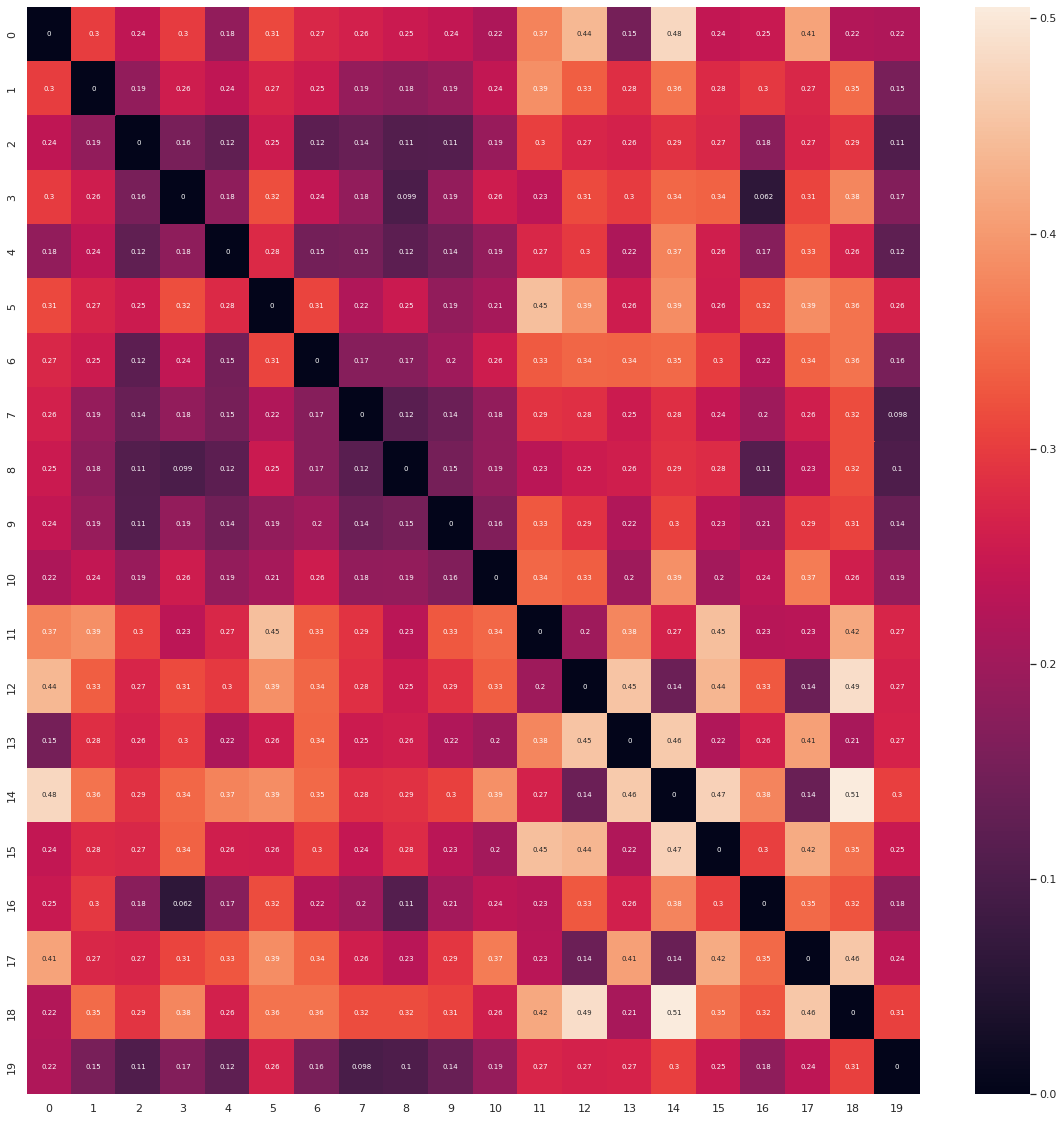

In [ ]:
# libraries
import seaborn as sns
import pandas as pd
import numpy as np


# plot a heatmap with annotation
### BE CARFULL SUUUUPER BIG AND LONG (8min)
# sns.set(rc={'figure.figsize':(200,200)})
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(pd.DataFrame(cosine_distances), annot=True, annot_kws={"size": 7})

In [ ]:
def find_bests(df_id, n_top):
  # We add 1 for the case of doc X compare to doc X
  n_top += 1
  row = results_df.iloc[df_id]
  print(row["CosinDistances"])
  my_list = row["CosinDistances"]
  max_values = nsmallest(n_top, my_list)
  print("Best match for", df_id, row["paper.value"])
  max_indexes = []
  for max_value in max_values[1:]:
    max_index = my_list.index(max_value)
    max_indexes.append(max_index)
    print("Is", max_index, results_df.iloc[max_index]["paper.value"])
    print("Distance is", max_value)
    print("Lang is", row["lang.value"], results_df.iloc[max_index]["lang.value"])
  print("-------")
  return max_indexes

In [ ]:
print(find_bests(2, 3))
print(find_bests(4, 3))

[0.23718804121017456, 0.18501853942871094, 0, 0.155567467212677, 0.12476474046707153, 0.25456517934799194, 0.12161314487457275, 0.13525205850601196, 0.1085660457611084, 0.11110150814056396, 0.19155269861221313, 0.30391865968704224, 0.2718878984451294, 0.26471465826034546, 0.2863039970397949, 0.2725662589073181, 0.17540794610977173, 0.26983213424682617, 0.29174065589904785, 0.10603117942810059]
Best match for 2 http://data-issa.cirad.fr/article/387424
Is 19 http://data-issa.cirad.fr/article/547124
Distance is 0.10603117942810059
Lang is eng fre
Is 8 http://data-issa.cirad.fr/article/388072
Distance is 0.1085660457611084
Lang is eng fre
Is 9 http://data-issa.cirad.fr/article/600125
Distance is 0.11110150814056396
Lang is eng fre
-------
[19, 8, 9]
[0.18383872509002686, 0.23748302459716797, 0.12476474046707153, 0.180911123752594, 0, 0.27777427434921265, 0.1498311161994934, 0.15308433771133423, 0.12152373790740967, 0.14454102516174316, 0.18620532751083374, 0.27384936809539795, 0.2967354655

Error detection is here : https://colab.research.google.com/drive/1ePtSW10HEu1mYfYk5U9P19_u29SE5stG?usp=sharing

In [ ]:
# # Return document id in dataframe and sum of cosine distances
# def find_errors(cosin_distances):
#   errors = []
#   for i, cosin_distance in enumerate(cosin_distances):
#     euristic = sum(cosin_distance)/len(cosin_distances)
#     # if euristic < 0.2: print("low", i, euristic)
#     if euristic > 0.35: errors.append([i, euristic])
#     # print(i, euristic)
#   return errors

In [ ]:
# print(find_errors(results_df["CosinDistances"]))

In [ ]:
# print(find_bests(43, 3))
# print(find_bests(124, 3))

In [ ]:
# for i, row in results_df.iterrows():
#   if i < 20:
#     my_list = row["CosinDistances"]
#     min_values = nsmallest(3, my_list)
#     # min_value = min(my_list)
#     print("Best match for", i, row["paper.value"])
#     min_indexes = []
#     for min_value in min_values:
#       min_index = my_list.index(min_value)
#       min_indexes.append(min_index)
#       print("Is", min_index, results_df.iloc[min_index]["paper.value"])
#       print("Distance is", min_value)
#       print("Lang is", row["lang.value"], results_df.iloc[min_index]["lang.value"])
#     print("-------")